In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import mat73
from pymatreader import read_mat
import json
from IPython.display import display
from scipy.fft import fft, fftfreq

%matplotlib inline

# Load Data

Load .mat file and .xlsx file, first holding the raw data and some metadata such as which picture was shown, marks for picture shown and picture placed and the latter holding iEEG channel information.

The resulting loaded data will be a data file holding

In [73]:
# Variable definitions
path_to_filepaths_file = './data/filepaths.json'
experiment_phase_of_interest = '2' # '1' is preview, '2' is learning, '3' is pre-sleep, and '4' is post-sleep

# Static definitions
fs = 512

In [74]:
class Preprocess():
    def __init__(self, path_to_filepaths_file, experiment_phase_of_interest, fs):
        print("initializing Preprocess class...")
        self.path_to_filepaths_file = path_to_filepaths_file
        self.experiment_phase_of_interest = experiment_phase_of_interest
        self.fs = fs
        
        # initiate variables
        self.dataone_filtered = None
        
        print(f"path_to_filepaths_file: {repr(self.path_to_filepaths_file)}")
        print(f"experiment_phase_of_interest: {repr(self.experiment_phase_of_interest)}")
        print(f"fs: {repr(self.fs)} Hz")
        
        # get filepaths and single subject ID
        print("getting filepaths...")
        self.filepaths, self.subject_id = self.get_filepaths()
        for key, value in self.filepaths.items():
            print(f"{key}: {repr(value)}")
        print(f"single subject ID is {repr(self.subject_id)}\n")
        
        # get single subject data
        print(f"loading single subject data (ID is {self.subject_id})...")
        self.datafullone = self.get_ieegdataone()
        print(f"type: {type(self.datafullone)}")
        print(f"keys: {self.datafullone.keys()}")
        print(f"data.keys: {self.datafullone['data'].keys()}")
        print(f"data.file2.shape: {self.datafullone['data'][f'file{self.experiment_phase_of_interest}'].shape}")
        print(f"data.ieeg_data2.shape: {self.datafullone['data'][f'ieeg_data{self.experiment_phase_of_interest}'].shape}")
        print("use <Class>.datafullone to access full data (including metadata)")
        
        # create own instance of data of interest
        self.dataone = self.datafullone['data'][f'ieeg_data{self.experiment_phase_of_interest}']
        print("use <Class>.dataone to only access iEEG data")
        
        # create dataframe of metadata
        print("creating dataframe of metadata...")
        self.df_metaone = self.get_metadataone()
        
        
    def get_filepaths(self):
        filepaths = json.loads(open(self.path_to_filepaths_file).read())
        subject_id = filepaths['single_subject'].split('sub')[-1][0:2]
        return filepaths, subject_id
    
    def get_ieegdataone(self):
        return read_mat(self.filepaths['single_subject'])
    
    def get_metadataone(self):
        """Parse metadata as Pandas dataframe"""
        df_metaone = pd.DataFrame(self.datafullone['data'][f'file{self.experiment_phase_of_interest}'], columns=['x_coordinate', 'y_coordinate', 'Picture Number', 'Reaction Time (RT)'])
        print("creating new columns 'Mark for Picture Shown' and 'Mark for Picture Placed'...")
        df_metaone['Mark for Picture Shown'] = self.datafullone['data'][f'mark{self.experiment_phase_of_interest}'][0::2]
        df_metaone['Mark for Picture Placed'] = self.datafullone['data'][f'mark{self.experiment_phase_of_interest}'][1::2]
        print("creating new columns 'Timestamp (s) for Picture Shown' and 'Timestamp (s) for Picture Placed'...")
        df_metaone['Timestamp (s) for Picture Shown'] = df_metaone['Mark for Picture Shown'].apply(lambda x: x/fs)
        df_metaone['Timestamp (s) for Picture Placed'] = df_metaone['Mark for Picture Placed'].apply(lambda x: x/fs)
        return df_metaone
        

In [75]:
Data = Preprocess(path_to_filepaths_file, experiment_phase_of_interest, fs)
Data.df_metaone.head()

initializing Preprocess class...
path_to_filepaths_file: './data/filepaths.json'
experiment_phase_of_interest: '2'
fs: 512 Hz
getting filepaths...
single_subject: './data/sub07.mat'
single_subject_ieeg_chan: './data/ieegchan_loc/sub07.xlsx'
all_subjects: ''
all_subjects_ieeg_chan: ''
single subject ID is '07'

loading single subject data (ID is 07)...


/home/mha/.pyvenv/sdcmaster/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


type: <class 'dict'>
keys: dict_keys(['#subsystem#', 'HP', 'ieeg_chan', 'data', 'file', 'scalp_chan'])
data.keys: dict_keys(['scalp_data2', 'file2', 'mark1', 'ieeg_data3', 'mark_data2', 'mark_data4', 'ieeg_data2', 'file4', 'scalp_data3', 'mark_data1', 'mark3', 'file1', 'ieeg_data1', 'scalp_data4', 'mark_data3', 'file3', 'mark4', 'scalp_data1', 'ieeg_data4', 'mark2'])
data.file2.shape: (425, 4)
data.ieeg_data2.shape: (113, 1363811)
use <Class>.datafullone to access full data (including metadata)
use <Class>.dataone to only access iEEG data
creating dataframe of metadata...
creating new columns 'Mark for Picture Shown' and 'Mark for Picture Placed'...
creating new columns 'Timestamp (s) for Picture Shown' and 'Timestamp (s) for Picture Placed'...


x_coordinate  y_coordinate  Picture Number  Reaction Time (RT)  \
0         -59.0        -225.0            43.0               680.0   
1         302.0         203.0            20.0               780.0   
2        -125.0         211.0             4.0               820.0   
3         255.0         189.0            36.0              1380.0   
4         366.0         170.0            35.0               620.0   

   Mark for Picture Shown  Mark for Picture Placed  \
0                  5119.0                   6226.0   
1                  7826.0                   9002.0   
2                 10605.0                  11824.0   
3                 13430.0                  15125.0   
4                 16724.0                  17768.0   

   Timestamp (s) for Picture Shown  Timestamp (s) for Picture Placed  
0                         9.998047                         12.160156  
1                        15.285156                         17.582031  
2                        20.712891                         23.093750  
3                        26.230469                         29.541016  
4                        32.664062                         34.703125

# Display Raw Data

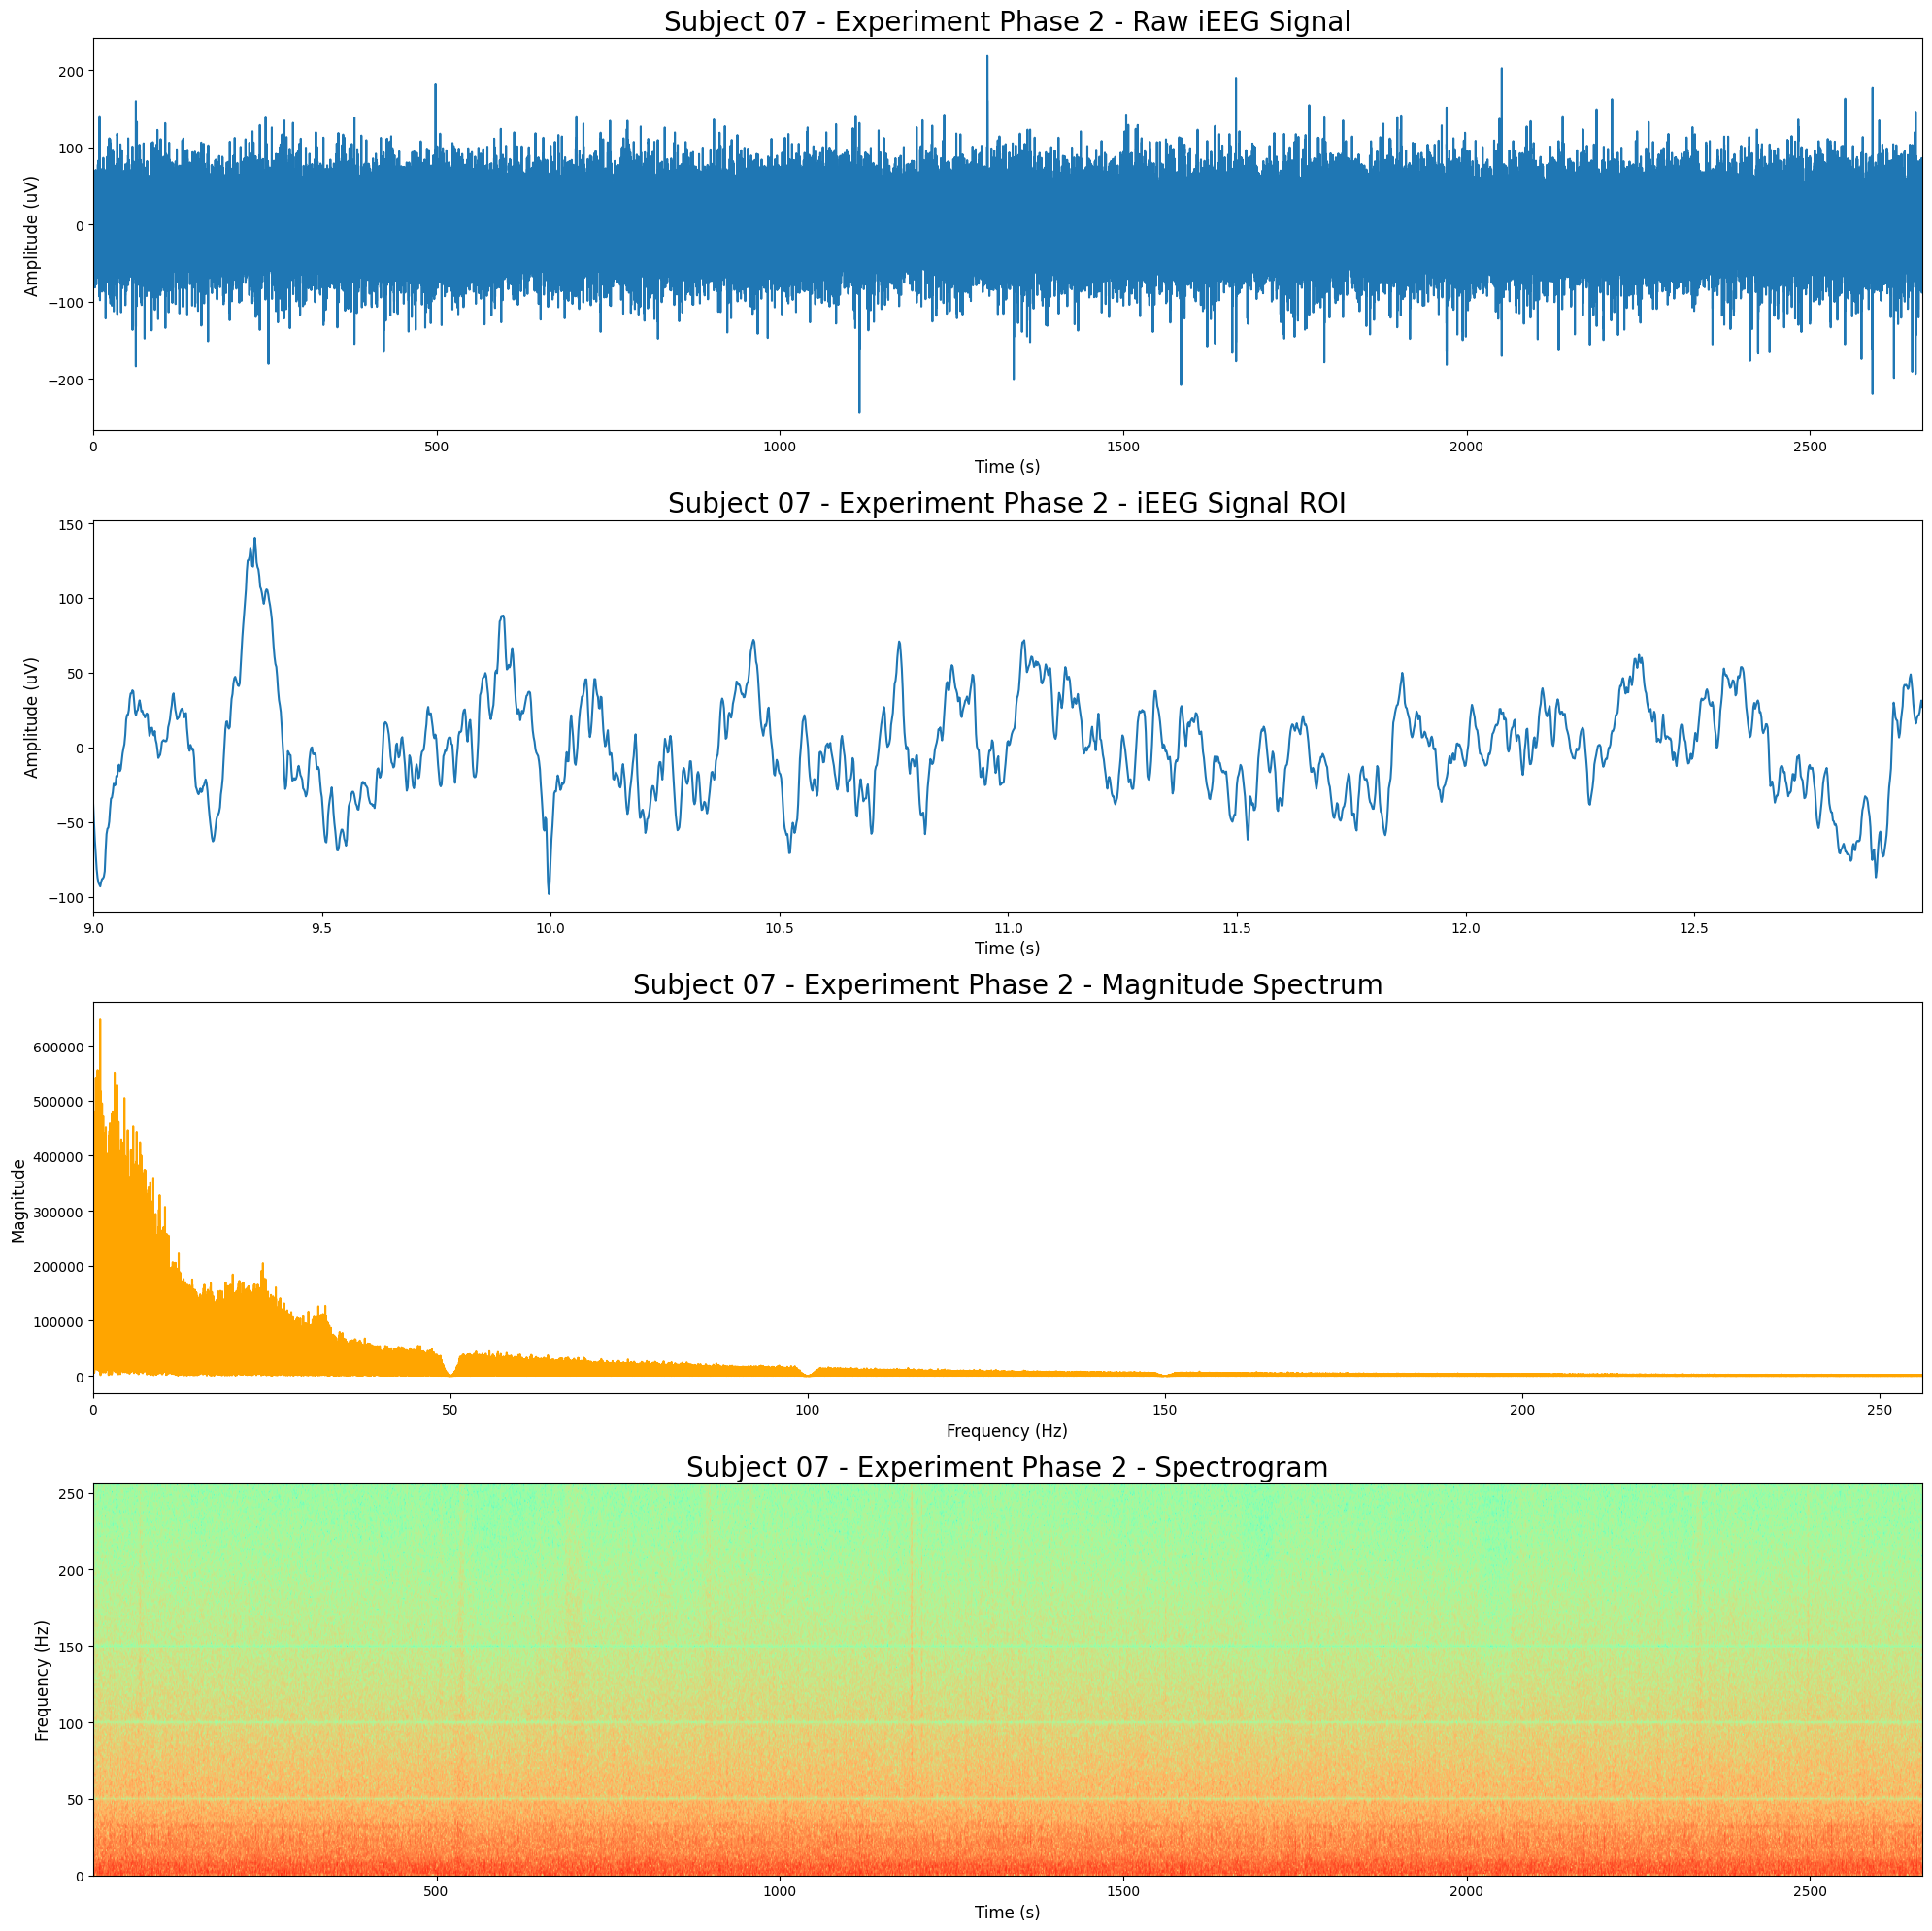

In [92]:
#******** Variable definitions ********
ieeg_contact = 0                                            # single iEEG contact to inspect
roi = [9, 13]                                               # ROI in seconds

#******** Static definitions ********
fs = 512                                                    # sample frequency
TT = Data.dataone.shape[1] / fs  # total time in seconds
t = np.arange(0, TT, 1/fs)                                  # full time vector
t_roi = np.arange(roi[0], roi[1], 1/fs)                     # ROI time vector

#******** Fourier transform ********
y = fft(Data.dataone[ieeg_contact, :])                      # FFT
xf = fftfreq(Data.dataone[ieeg_contact, :].size, 1/fs)      # Frequency vector
xf = xf[xf>=0]                                              # Only positive frequencies
y = np.abs(y)[:len(xf)]                                     # Magnitude of FFT (one sided)


#******** Plotting ********
fig, ax = plt.subplots(4, 1, figsize=(20, 20))

# Entire signal
ax[0].plot(t, Data.dataone[ieeg_contact, :])
ax[0].set_title(f'Subject {Data.subject_id} - Experiment Phase {experiment_phase_of_interest} - Raw iEEG Signal', fontsize=20)
ax[0].set_xlabel('Time (s)', fontsize=12)
ax[0].set_ylabel('Amplitude (uV)', fontsize=12)
ax[0].set_xlim([t[0], t[-1]])

# ROI
ax[1].plot(t_roi, Data.dataone[ieeg_contact, roi[0]*fs:roi[1]*fs])
ax[1].set_title(f'Subject {Data.subject_id} - Experiment Phase {experiment_phase_of_interest} - iEEG Signal ROI', fontsize=20)
ax[1].set_xlabel('Time (s)', fontsize=12)
ax[1].set_ylabel('Amplitude (uV)', fontsize=12)
ax[1].set_xlim([t_roi[0], t_roi[-1]])

# Magnitude spectrum
ax[2].plot(xf, y, color='orange')
ax[2].set_title(f'Subject {Data.subject_id} - Experiment Phase {experiment_phase_of_interest} - Magnitude Spectrum', fontsize=20)
ax[2].set_xlabel('Frequency (Hz)', fontsize=12)
ax[2].set_ylabel('Magnitude', fontsize=12)
ax[2].set_xlim([xf[0], xf[-1]])

# Spectrogram
pxx, freqs, _t, img = ax[3].specgram(Data.dataone[ieeg_contact, :], Fs=fs, NFFT=512, noverlap=64, cmap='rainbow')
ax[3].set_title(f'Subject {Data.subject_id} - Experiment Phase {experiment_phase_of_interest} - Spectrogram', fontsize=20)
ax[3].set_xlabel('Time (s)', fontsize=12)
ax[3].set_ylabel('Frequency (Hz)', fontsize=12)

plt.tight_layout()

# Filter Signal

In [106]:
def digital_filter(in_signal=None, order=4, cutoff=500, fs=1000, filter_type='high', apply_filter=False, show_bodeplot=True, show_impulse_response=True, len_impulse=1000):
    """digital_filter Create a digital filter using scipy's butter function.

    Create a digital filter using scipy's butter function and compute the
    filter frequency response. The filter frequency response is always plotted
    as part in ensuring the desired filter design.

    Args:
        in_signal (_type_, optional): If specified and apply_filter is set to True, the filter is applied to the signal 
                                      and the filtered signal is returned. Defaults to None.
        order (int, optional): The order of the filter. Defaults to 4.
        cutoff (int or vector, optional): The cutoff frequency of the filter (in Hz). If filter_type is 'bandpass' or
                                          'bandstop' cutoff is a length-2 vector. Defaults to 500.
        fs (int, optional): The sampling frequency used to sample the signal. Defaults to 1000.
        filter_type (str, optional): The type of filter ('lowpass', 'highpass', 'bandstop', 'bandpass'). Defaults to 'high'.
        apply_filter (bool, optional): If True then the filter is applied to the signal in_signal. Defaults to False.
        show_bodeplot (bool, optional): If True then the bode plot of the filter frequency response is plotted. Defaults to True.
        show_impulse_response (bool, optional): If True then the impulse response of the filter is plotted. Defaults to True.
        len_impulse (int, optional): The length of the impulse response. If not specified defaults to 1000.

    Returns:
        b, a (ndarray): Default setting for function is to return the 
                        filter coefficients.
        out_signal (ndarray): If apply_filter is set to True and in_signal 
                              is given, the function will apply the digital 
                              filter and return the filtered signal.
    """
    # Create digital filter
    b, a = signal.butter(N=order, Wn=cutoff, btype=filter_type, fs=fs, analog=False)
    
    # Compute digital filter frequency response
    w, h = signal.freqz(b, a, fs=fs)
    
    # Generate and compute impulse response
    impulse = signal.unit_impulse(len_impulse)                                  # create impulse
    t_impulse = np.arange(-(len_impulse//10), len_impulse-(len_impulse//10))    # create time vector for impulse
    response = signal.lfilter(b, a, impulse)                                    # compute filter response to impulse
    
    # Plotting
    if show_bodeplot and show_impulse_response:
        fig, ax = plt.subplots(1, 2, figsize=(20, 7))
        # Bode plot
        ax[0].semilogx(w, 20*np.log10(abs(h)), linewidth=3)
        ax[0].set_title("Digital Filter Frequency Response", fontsize=20)
        ax[0].set_xlabel("Frequency [Hz]", fontsize=16)
        ax[0].set_ylabel("Amplitude [dB]", fontsize=16)
        ax[0].grid(which='both', axis='both')
        if filter_type in ('low', 'lowpass'): ax[0].margins(0, 0.15)
        if filter_type in ('high', 'highpass'): ax[0].margins(0.15, 0.1)
        if filter_type in ('bs', 'bandstop', 'bp', 'bandpass'): 
            ax[0].axvline(cutoff[0], color='orange', label=f"Cutoff frequency start ({cutoff[0]} Hz)", linewidth=2, linestyle='--')
            ax[0].axvline(cutoff[1], color='orange', label=f"Cutoff frequency stop ({cutoff[1]} Hz)", linewidth=2, linestyle='--')
        if filter_type not in ('bs', 'bandstop', 'bp', 'bandpass'): 
            ax[0].semilogx(cutoff, 20*np.log10(0.5*np.sqrt(2)), '*') # plot a star symbol at -3 dB attenuation
            ax[0].axvline(cutoff, color='orange', label=f"Cutoff frequency ({cutoff} Hz)", linewidth=2, linestyle='--')
        # Impulse response plot
        ax[1].plot(t_impulse, impulse, 'b-', label='Impulse')
        ax[1].plot(t_impulse, response, 'g-', linewidth=2, label='Response')
        ax[1].set_title('Impulse and Response of Digital Filter', fontsize=20)
        ax[1].set_xlabel('Time [sec]', fontsize=16)
        ax[1].set_ylabel('Amplitude', fontsize=16)
        ax[1].grid(which='both', axis='both')
        plt.legend(loc='best', fontsize=12, shadow=True)
        plt.tight_layout()
    elif show_bodeplot:
        fig, ax = plt.subplots(1, 1, figsize=(12, 7))
        ax[0].semilogx(w, 20*np.log10(abs(h)), linewidth=3)
        ax[0].set_title("Digital Filter Frequency Response", fontsize=20)
        ax[0].set_xlabel("Frequency [Hz]", fontsize=16)
        ax[0].set_ylabel("Amplitude [dB]", fontsize=16)
        ax[0].grid(which='both', axis='both')
        if filter_type in ('low', 'lowpass'): ax[0].margins(0, 0.15)
        if filter_type in ('high', 'highpass'): ax[0].margins(0.15, 0.1)
        if filter_type in ('bs', 'bandstop', 'bp', 'bandpass'): 
            ax[0].axvline(cutoff[0], color='orange', label=f"Cutoff frequency start ({cutoff[0]} Hz)", linewidth=2, linestyle='--')
            ax[0].axvline(cutoff[1], color='orange', label=f"Cutoff frequency stop ({cutoff[1]} Hz)", linewidth=2, linestyle='--')
        if filter_type not in ('bs', 'bandstop', 'bp', 'bandpass'): 
            ax[0].semilogx(cutoff, 20*np.log10(0.5*np.sqrt(2)), '*') # plot a star symbol at -3 dB attenuation
            ax[0].axvline(cutoff, color='orange', label=f"Cutoff frequency ({cutoff} Hz)", linewidth=2, linestyle='--')
        plt.legend(loc='best', fontsize=12, shadow=True)
        plt.tight_layout()
    elif show_impulse_response:
        fig, ax = plt.subplots(1, 1, figsize=(12, 7))
        ax[0].plot(t_impulse, impulse, 'b-', label='Impulse')
        ax[0].plot(t_impulse, response, 'g-', linewidth=2, label='Response')
        ax[0].set_title('Impulse and Response of Digital Filter', fontsize=20)
        ax[0].set_xlabel('Time [sec]', fontsize=16)
        ax[0].set_ylabel('Amplitude', fontsize=16)
        ax[0].grid(which='both', axis='both')
        plt.legend(loc='best', fontsize=12, shadow=True)
        plt.tight_layout()
    else:
        pass
    
    if apply_filter == True and in_signal is not None:
        # Apply filter and return filtered signal
        out_signal = signal.lfilter(b, a, in_signal)
        return out_signal
    else:
        # (Defualt) Return the filter coefficients
        return b, a

/tmp/ipykernel_4900/2606972710.py:43: RuntimeWarning: divide by zero encountered in log10
  ax[0].semilogx(w, 20*np.log10(abs(h)), linewidth=3)


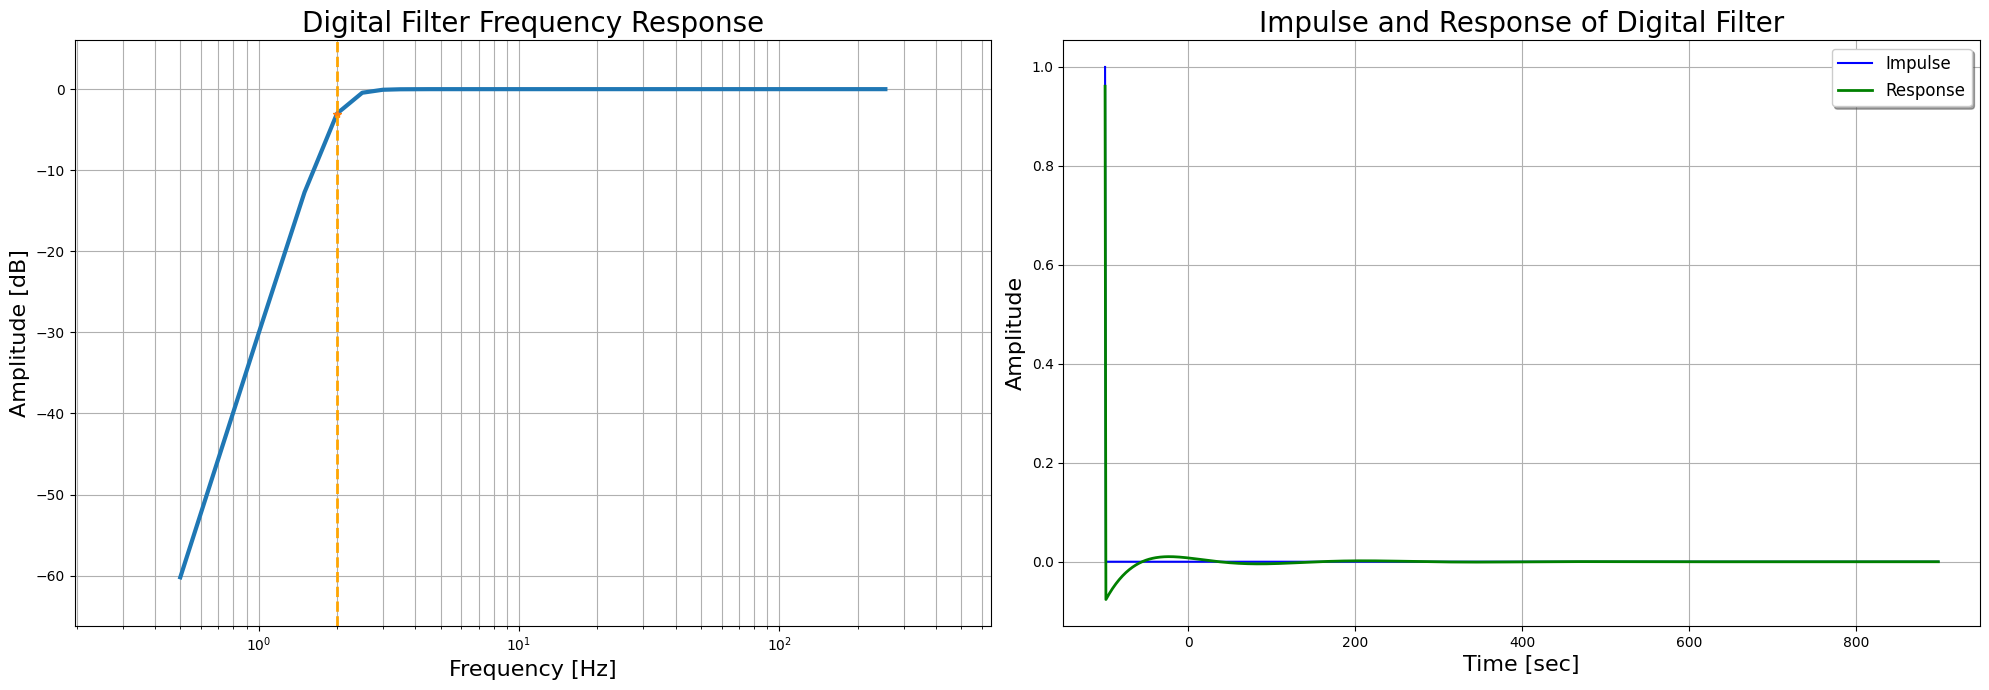

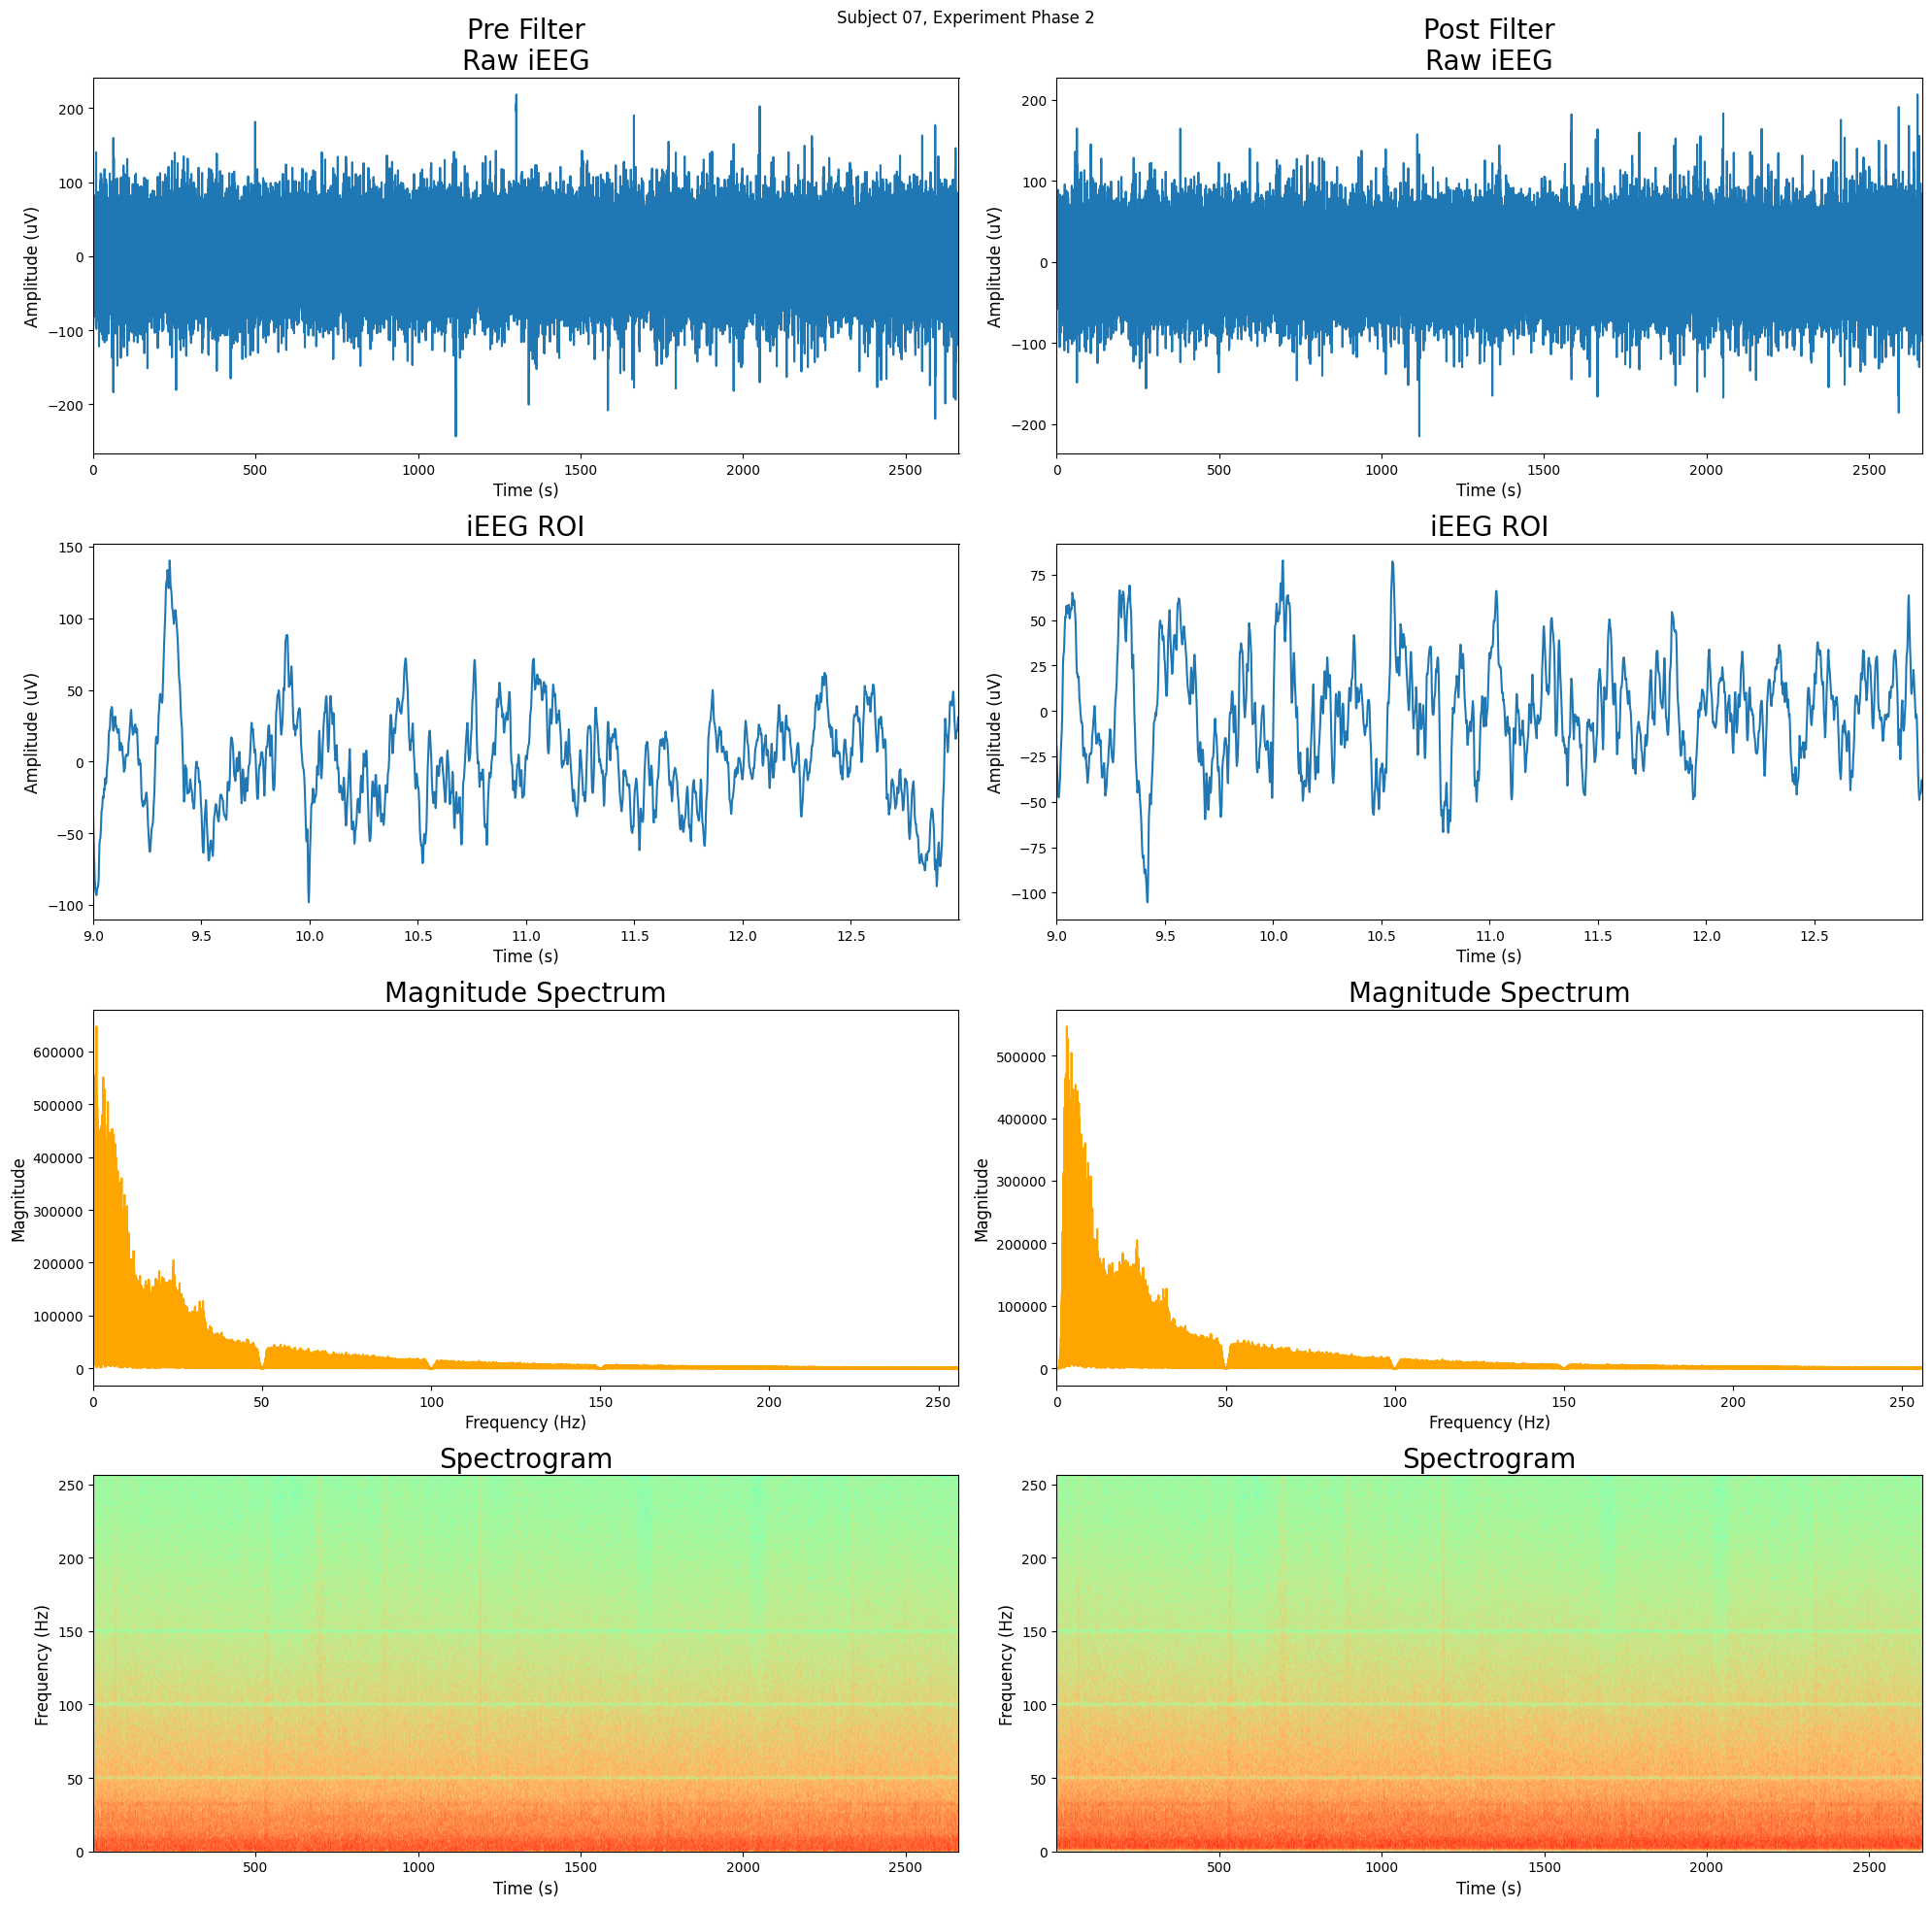

In [107]:
#******** Highpass filter data ********
# Note:
#   Remove low frequency drifts.
Data.dataone_filtered = digital_filter(in_signal=Data.dataone[ieeg_contact, :],
                                        order=5,
                                        cutoff=2,
                                        filter_type='highpass',
                                        fs=fs,
                                        apply_filter=True)


#******** Fourier transform ********
y_pre = fft(Data.dataone[ieeg_contact, :])                      # FFT
xf_pre = fftfreq(Data.dataone[ieeg_contact, :].size, 1/fs)      # Frequency vector
xf_pre = xf_pre[xf_pre>=0]                                      # Only positive frequencies
y_pre = np.abs(y_pre)[:len(xf_pre)]                             # Magnitude of FFT (one sided)

y_post = fft(Data.dataone_filtered)                             # FFT
xf_post = fftfreq(Data.dataone_filtered.size, 1/fs)             # Frequency vector
xf_post = xf_post[xf_post>=0]                                   # Only positive frequencies
y_post = np.abs(y_post)[:len(xf_post)]                          # Magnitude of FFT (one sided)


#******** Plotting (pre filtering) ********
fig, ax = plt.subplots(4, 2, figsize=(20, 20))

# Entire signal
ax[0,0].plot(t, Data.dataone[ieeg_contact, :])
ax[0,0].set_title('Pre Filter\nRaw iEEG', fontsize=20)
ax[0,0].set_xlabel('Time (s)', fontsize=12)
ax[0,0].set_ylabel('Amplitude (uV)', fontsize=12)
ax[0,0].set_xlim([t[0], t[-1]])

# ROI
ax[1,0].plot(t_roi, Data.dataone[ieeg_contact, roi[0]*fs:roi[1]*fs])
ax[1,0].set_title('iEEG ROI', fontsize=20)
ax[1,0].set_xlabel('Time (s)', fontsize=12)
ax[1,0].set_ylabel('Amplitude (uV)', fontsize=12)
ax[1,0].set_xlim([t_roi[0], t_roi[-1]])

# Magnitude spectrum
ax[2,0].plot(xf_pre, y_pre, color='orange')
ax[2,0].set_title('Magnitude Spectrum', fontsize=20)
ax[2,0].set_xlabel('Frequency (Hz)', fontsize=12)
ax[2,0].set_ylabel('Magnitude', fontsize=12)
ax[2,0].set_xlim([xf_pre[0], xf_pre[-1]])

# Spectrogram
pxx_pre, freqs_pre, _t_pre, img_pre = ax[3,0].specgram(Data.dataone[ieeg_contact, :], Fs=fs, NFFT=512, noverlap=64, cmap='rainbow')
ax[3,0].set_title('Spectrogram', fontsize=20)
ax[3,0].set_xlabel('Time (s)', fontsize=12)
ax[3,0].set_ylabel('Frequency (Hz)', fontsize=12)

#******** Plotting (post filtering) ********
# Entire signal
ax[0,1].plot(t, Data.dataone_filtered)
ax[0,1].set_title('Post Filter\nRaw iEEG', fontsize=20)
ax[0,1].set_xlabel('Time (s)', fontsize=12)
ax[0,1].set_ylabel('Amplitude (uV)', fontsize=12)
ax[0,1].set_xlim([t[0], t[-1]])

# ROI
ax[1,1].plot(t_roi, Data.dataone_filtered[roi[0]*fs:roi[1]*fs])
ax[1,1].set_title('iEEG ROI', fontsize=20)
ax[1,1].set_xlabel('Time (s)', fontsize=12)
ax[1,1].set_ylabel('Amplitude (uV)', fontsize=12)
ax[1,1].set_xlim([t_roi[0], t_roi[-1]])

# Magnitude spectrum
ax[2,1].plot(xf_post, y_post, color='orange')
ax[2,1].set_title('Magnitude Spectrum', fontsize=20)
ax[2,1].set_xlabel('Frequency (Hz)', fontsize=12)
ax[2,1].set_ylabel('Magnitude', fontsize=12)
ax[2,1].set_xlim([xf_post[0], xf_post[-1]])

# Spectrogram
pxx_post, freqs_post, _t_post, img_post = ax[3,1].specgram(Data.dataone_filtered, Fs=fs, NFFT=512, noverlap=64, cmap='rainbow')
ax[3,1].set_title('Spectrogram', fontsize=20)
ax[3,1].set_xlabel('Time (s)', fontsize=12)
ax[3,1].set_ylabel('Frequency (Hz)', fontsize=12)

fig.suptitle(f"Subject {Data.subject_id}, Experiment Phase {experiment_phase_of_interest}", fontdict={'size': 30, 'weight': 'bold'})
plt.tight_layout()

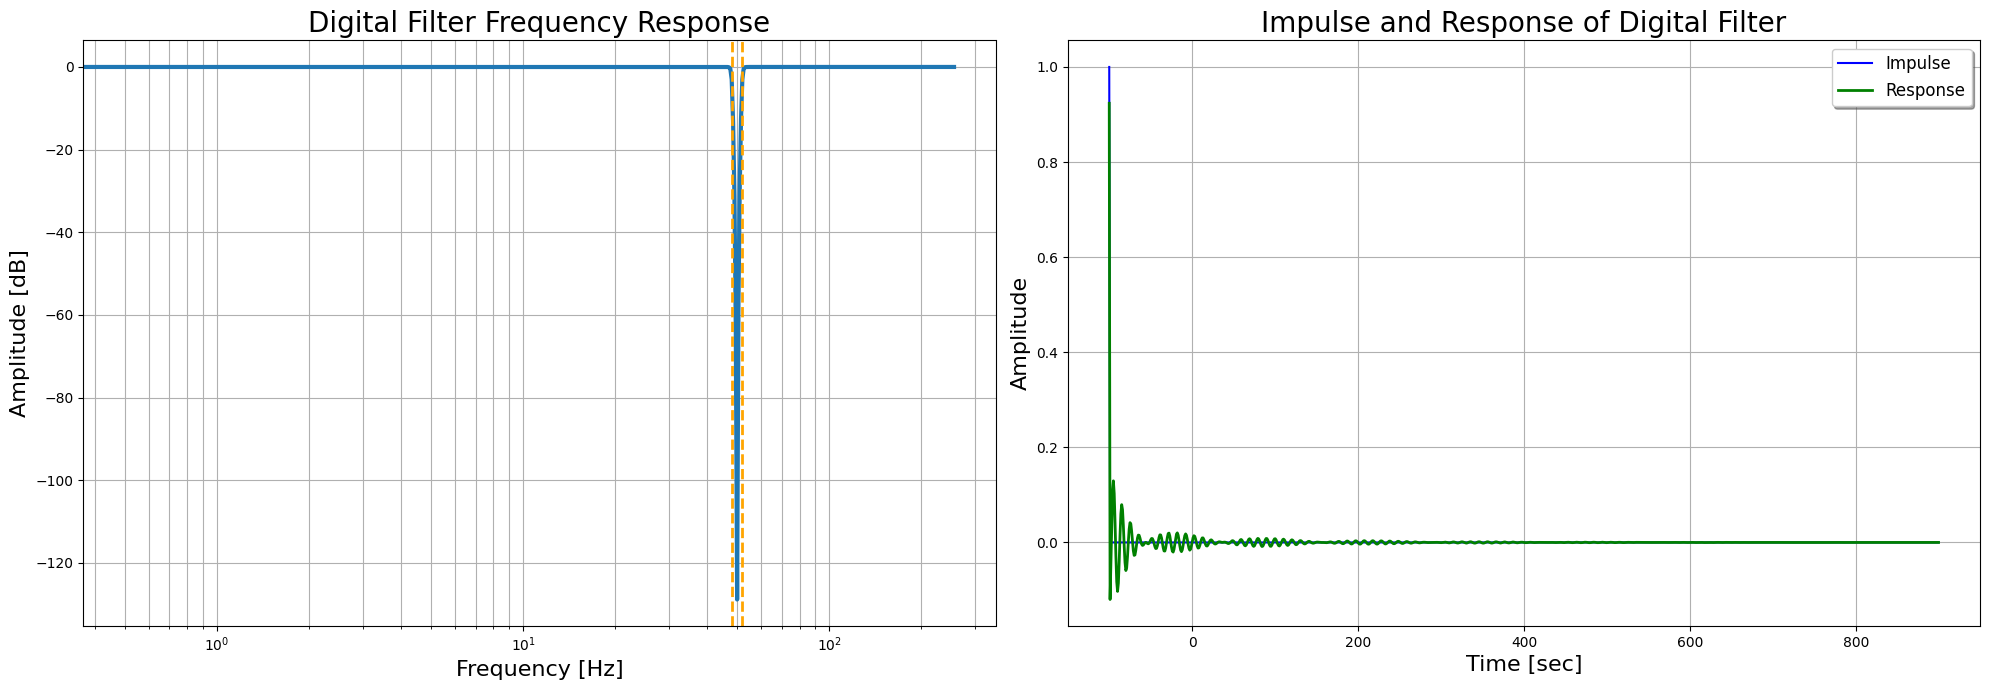

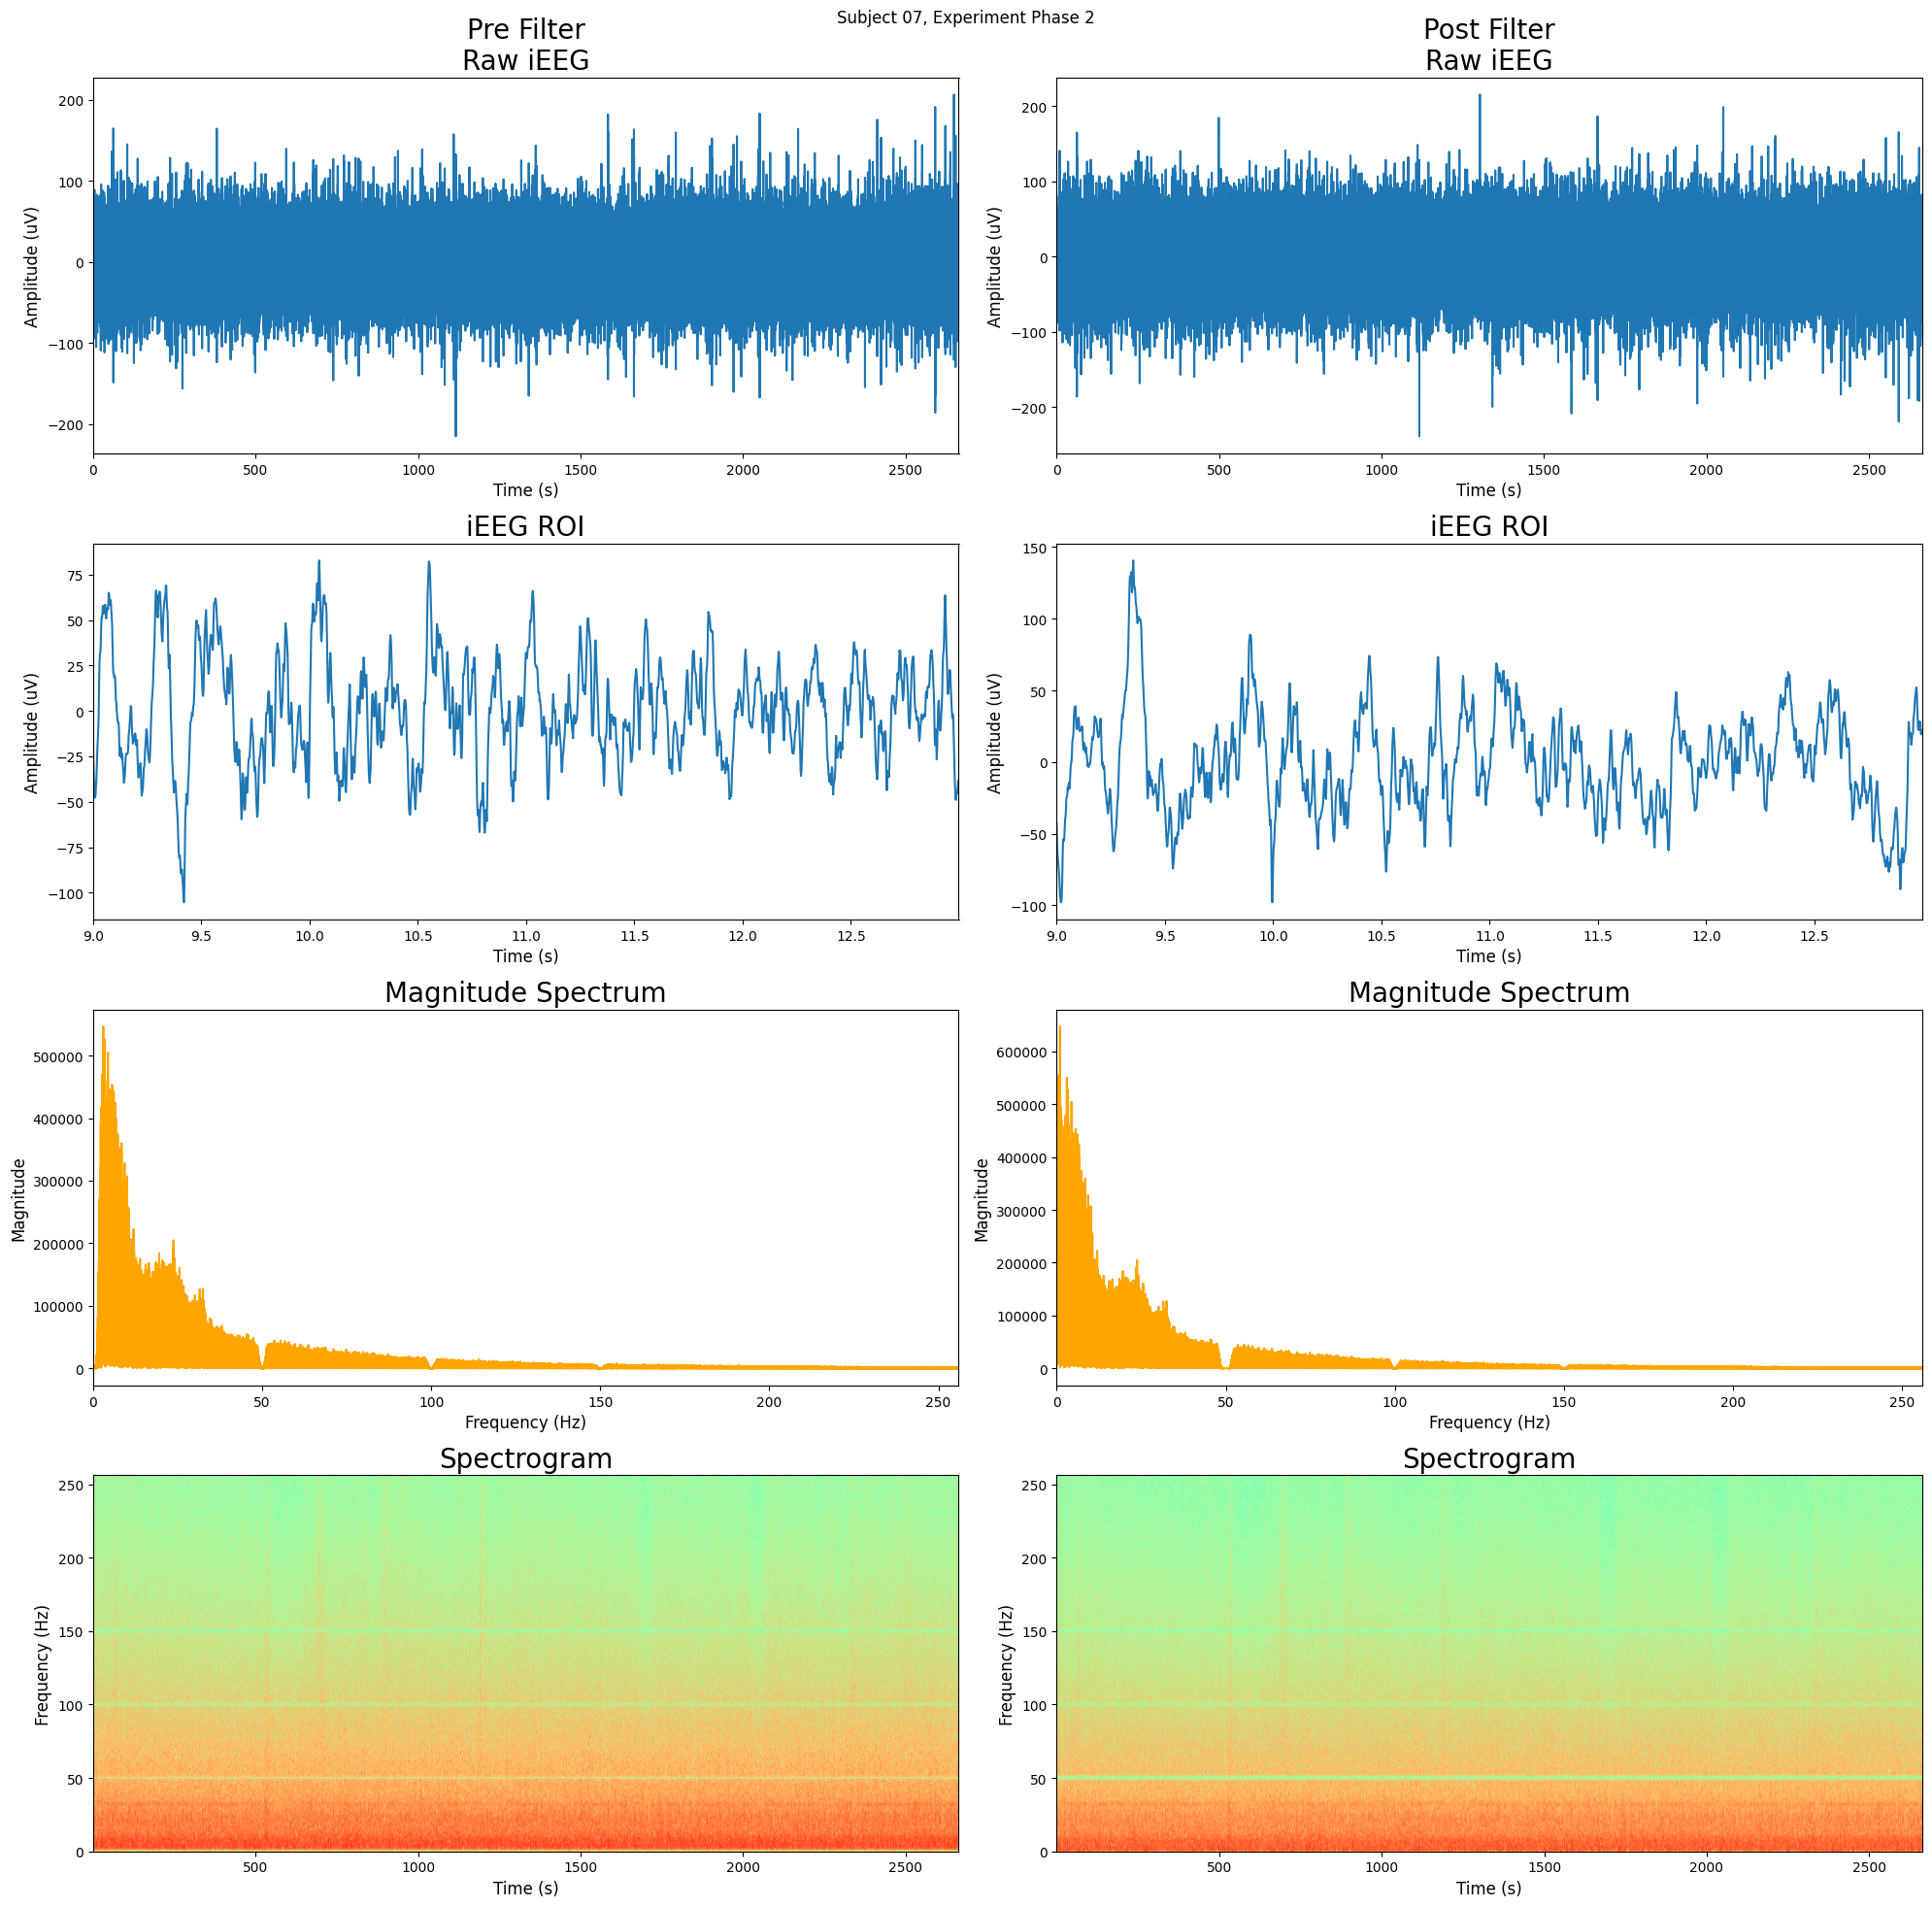

In [108]:
# temporary variable holding pre highpass filtered data
tmp_dataone_highpass = Data.dataone_filtered

#******** Bandstop filter data ********
# Note:
#   Remove powerline frequency noise.
Data.dataone_filtered = digital_filter(in_signal=Data.dataone[ieeg_contact, :],
                                        order=5,
                                        cutoff=[48, 52],
                                        filter_type='bandstop',
                                        fs=fs,
                                        apply_filter=True)


#******** Fourier transform ********
y_pre = fft(tmp_dataone_highpass)                      # FFT
xf_pre = fftfreq(tmp_dataone_highpass.size, 1/fs)      # Frequency vector
xf_pre = xf_pre[xf_pre>=0]                                      # Only positive frequencies
y_pre = np.abs(y_pre)[:len(xf_pre)]                             # Magnitude of FFT (one sided)

y_post = fft(Data.dataone_filtered)                             # FFT
xf_post = fftfreq(Data.dataone_filtered.size, 1/fs)             # Frequency vector
xf_post = xf_post[xf_post>=0]                                   # Only positive frequencies
y_post = np.abs(y_post)[:len(xf_post)]                          # Magnitude of FFT (one sided)


#******** Plotting (pre filtering) ********
fig, ax = plt.subplots(4, 2, figsize=(20, 20))

# Entire signal
ax[0,0].plot(t, tmp_dataone_highpass)
ax[0,0].set_title('Pre Filter\nRaw iEEG', fontsize=20)
ax[0,0].set_xlabel('Time (s)', fontsize=12)
ax[0,0].set_ylabel('Amplitude (uV)', fontsize=12)
ax[0,0].set_xlim([t[0], t[-1]])

# ROI
ax[1,0].plot(t_roi, tmp_dataone_highpass[roi[0]*fs:roi[1]*fs])
ax[1,0].set_title('iEEG ROI', fontsize=20)
ax[1,0].set_xlabel('Time (s)', fontsize=12)
ax[1,0].set_ylabel('Amplitude (uV)', fontsize=12)
ax[1,0].set_xlim([t_roi[0], t_roi[-1]])

# Magnitude spectrum
ax[2,0].plot(xf_pre, y_pre, color='orange')
ax[2,0].set_title('Magnitude Spectrum', fontsize=20)
ax[2,0].set_xlabel('Frequency (Hz)', fontsize=12)
ax[2,0].set_ylabel('Magnitude', fontsize=12)
ax[2,0].set_xlim([xf_pre[0], xf_pre[-1]])

# Spectrogram
pxx_pre, freqs_pre, _t_pre, img_pre = ax[3,0].specgram(tmp_dataone_highpass, Fs=fs, NFFT=512, noverlap=64, cmap='rainbow')
ax[3,0].set_title('Spectrogram', fontsize=20)
ax[3,0].set_xlabel('Time (s)', fontsize=12)
ax[3,0].set_ylabel('Frequency (Hz)', fontsize=12)

#******** Plotting (post filtering) ********
# Entire signal
ax[0,1].plot(t, Data.dataone_filtered)
ax[0,1].set_title('Post Filter\nRaw iEEG', fontsize=20)
ax[0,1].set_xlabel('Time (s)', fontsize=12)
ax[0,1].set_ylabel('Amplitude (uV)', fontsize=12)
ax[0,1].set_xlim([t[0], t[-1]])

# ROI
ax[1,1].plot(t_roi, Data.dataone_filtered[roi[0]*fs:roi[1]*fs])
ax[1,1].set_title('iEEG ROI', fontsize=20)
ax[1,1].set_xlabel('Time (s)', fontsize=12)
ax[1,1].set_ylabel('Amplitude (uV)', fontsize=12)
ax[1,1].set_xlim([t_roi[0], t_roi[-1]])

# Magnitude spectrum
ax[2,1].plot(xf_post, y_post, color='orange')
ax[2,1].set_title('Magnitude Spectrum', fontsize=20)
ax[2,1].set_xlabel('Frequency (Hz)', fontsize=12)
ax[2,1].set_ylabel('Magnitude', fontsize=12)
ax[2,1].set_xlim([xf_post[0], xf_post[-1]])

# Spectrogram
pxx_post, freqs_post, _t_post, img_post = ax[3,1].specgram(Data.dataone_filtered, Fs=fs, NFFT=512, noverlap=64, cmap='rainbow')
ax[3,1].set_title('Spectrogram', fontsize=20)
ax[3,1].set_xlabel('Time (s)', fontsize=12)
ax[3,1].set_ylabel('Frequency (Hz)', fontsize=12)

fig.suptitle(f"Subject {Data.subject_id}, Experiment Phase {experiment_phase_of_interest}", fontdict={'size': 30, 'weight': 'bold'})
plt.tight_layout()